In [151]:
from meal_identification.datasets.dataset_operations import get_root_dir
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_data(file='2024-11-15_500030__i5mins_d4hrs_c5g_l2hrs_n3.csv') -> pd.DataFrame:
    data_path='0_meal_identification/meal_identification/data/interim'
    project_root = get_root_dir()
    full_raw_loc_path = os.path.join(project_root, data_path)
    file_path = os.path.join(full_raw_loc_path, file)
    return pd.read_csv(file_path, usecols=['date', 'bgl', 'msg_type', 'day_start_shift'], parse_dates=['date'])

def generate_meal_periods(df: pd.DataFrame, n_rows=6, n_steps=1) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Add meal time n_rows after each ANNOUNCE_MEAL and calculate derivative. 
    Basically, we wanted to create a period of meal time.
    
    Parameters
    ----------
        df: DataFrame containing the BGL data
        n_rows: Number of rows to label as ANNOUNCE_MEAL after each ANNOUNCE_MEAL
        n_steps: Number of time steps
    Returns
    -------
        DataFrame with processed and smoothed data
    """
    print (f"Each meal lasts {n_rows*5} mins")
    meal_indices = df[df['msg_type'] == 'ANNOUNCE_MEAL'].index
    for idx in meal_indices:
        next_indices = range(idx + 1, min(idx + n_rows + 1, len(df)))
    
        # Set those rows' msg_type to ANNOUNCE_MEAL
        df.loc[next_indices, 'msg_type'] = 'ANNOUNCE_MEAL'
    
    df['bgl_rate'] = df['bgl'].diff(periods=n_steps) / (5.0 * n_steps)  # divide by total minutes to get rate
    normalized_df = normalize_df(df)
    meal_df = normalized_df[normalized_df['msg_type'] == 'ANNOUNCE_MEAL']
    non_meal_df = normalized_df[normalized_df['msg_type'] != 'ANNOUNCE_MEAL']
    return meal_df, non_meal_df

def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize numeric columns in the DataFrame using z-score normalization (StandardScaler).
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame to normalize
        
    Returns
    -------
    pd.DataFrame
        Normalized DataFrame with non-numeric columns preserved
    """
    # Create a copy to avoid modifying the original
    df_normalized = df.copy()
    
    # Calculate mean and std for each numeric column
    for column in df.columns:
        if column in ['bgl', 'bgl_rate']:  # Only normalize BGL-related columns
            mean = df[column].mean()
            std = df[column].std()
            
            # Avoid division by zero
            if std == 0:
                df_normalized[column] = 0
            else:
                df_normalized[column] = (df[column] - mean) / std
    
    return df_normalized


def plot_histograms(meal_df: pd.DataFrame, non_meal_df: pd.DataFrame, file, bgl_bins=30, rate_bins=20, ):
    # Common axis parameters
    def style_axis(ax, title, xlabel):
        ax.set_title(title, pad=15, fontsize=12, fontweight='bold')
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=10)
        
    # Set fixed width for histogram
    bgl_min = min(meal_df['bgl'].min(), non_meal_df['bgl'].min())
    bgl_max = max(meal_df['bgl'].max(), non_meal_df['bgl'].max())
    rate_min = min(meal_df['bgl_rate'].min(), non_meal_df['bgl_rate'].min())
    rate_max = max(meal_df['bgl_rate'].max(), non_meal_df['bgl_rate'].max())
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    plt.title = file
    
    bgl_bins= np.linspace(bgl_min, bgl_max, bgl_bins + 1)
    rate_bins = np.linspace(rate_min, rate_max, rate_bins + 1)
    hist_params = dict(
        stat='density',
        alpha=0.5,  # Reduced alpha for better overlay visibility
        edgecolor='white',
        linewidth=1,
    )
    
    # Plot both distributions on the same axes
    sns.histplot(data=meal_df['bgl'], ax=ax1, color='r', bins=bgl_bins,
                label=f'Meal Events (n={len(meal_df):,})', **hist_params)
    sns.histplot(data=non_meal_df['bgl'], ax=ax1, color='b',bins=bgl_bins,
                label=f'Non-Meal Events (n={len(non_meal_df):,})', **hist_params)
    
    style_axis(ax1, 'Blood Glucose Level Distribution - Meal vs Non-Meal Events', 'Blood Glucose Level (mg/dL)')
    ax1.set_xlim(bgl_min, bgl_max)
    ax1.legend(frameon=True, fontsize=10)
    
    sns.histplot(data=meal_df['bgl_rate'], ax=ax2, color='r', bins=rate_bins,
                label=f'Meal Events (n={len(meal_df):,})', **hist_params)
    sns.histplot(data=non_meal_df['bgl_rate'], ax=ax2, color='b', bins=rate_bins,
                label=f'Non-Meal Events (n={len(non_meal_df):,})', **hist_params)
    
    style_axis(ax1, 'Blood Glucose Level Distribution - Meal vs Non-Meal Events', 'Blood Glucose Level')
    ax1.set_xlim(bgl_min, bgl_max)
    ax1.legend(frameon=True, fontsize=10)
    
    style_axis(ax2, 'Blood Glucose Rate Distribution - Meal vs Non-Meal Events', 'Blood Glucose Rate')
    ax2.set_xlim(rate_min, rate_max)
    ax2.legend(frameon=True, fontsize=10)
    
    
    
    plt.tight_layout()
    
    # statistics
    print(f"BGL range: {bgl_min:.1f} to {bgl_max:.1f}")
    print(f"Rate range: {rate_min:.1f} to {rate_max:.1f}")
    print(f"\nNumber of meal rows: {len(meal_df)}")
    print(f"Number of non-meal rows: {len(non_meal_df)}")


## Generate data
 - Adjust `index` to see different files in `data/interim` </br>
 - Adjust `n_rows` to change meal period. Each row is 5 mins. Default to 6 rows (30 mins)
 - Adjust `n_step` to change the time step of derivative
 - Adjust `bgl_bins` to change number of bins for bgl
 - Adjust `rate_bins` to change number of bins of derivative

File selected: 2024-11-15_679372__i5mins_d4hrs_c5g_l3hrs_n3.csv
Each meal lasts 100 mins
BGL range: -2.4 to 7.5
Rate range: -8.0 to 8.7

Number of meal rows: 3129
Number of non-meal rows: 23367


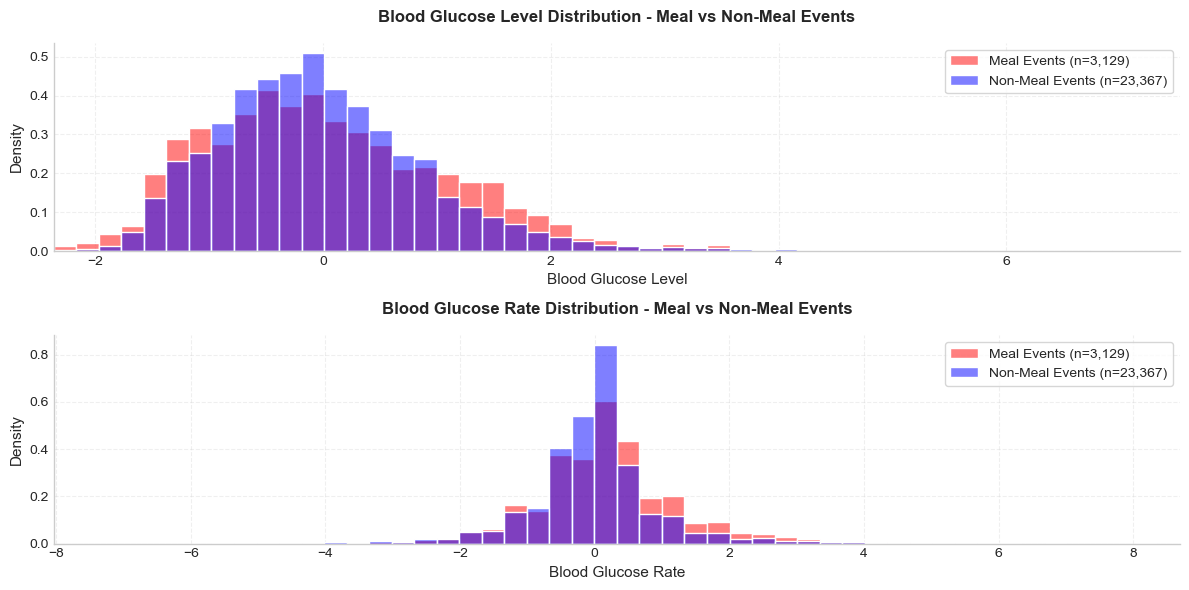

In [154]:
index = -2
n_rows = 20
n_step = 1
bgl_bins = 50
rate_bins = 40

csv_files = [f for f in os.listdir('../data/interim') if f.endswith('.csv')]
file = csv_files[index]
print(f"File selected: {file}")
df = load_data(file)
meal_df, non_meal_df = generate_meal_periods(df, n_rows=20, n_steps=1)
plot_histograms(meal_df, non_meal_df, file, bgl_bins=50, rate_bins=50)
